Ensemble (hybrid search) Retriever - "comparing population" problem

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import Qdrant
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter
from dotenv import load_dotenv
load_dotenv()

In [11]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

with open('../langchain/lcel/custom_embedding/data/Toronto.txt', 'r') as f:
    html_toronto = f.read()
with open('../langchain/lcel/custom_embedding/data/San_Francisco.txt', 'r') as f:
    html_sf = f.read()
headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
    ("h3", "Header 3"),
]
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
toronto_header_splits = html_splitter.split_text(html_toronto)
sf_header_splits = html_splitter.split_text(html_sf)

toronto_header_splits[0].metadata = {"Header2": "Overview", "Header 3": "population"}
sf_header_splits[0].metadata = {"Header2": "Overview", "Header 3": "population"}
total_headers = toronto_header_splits + sf_header_splits

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(total_headers)

The downside is: Qdrant doesn't support BM25, so we technically have 2 databases: texts and Qdrant.

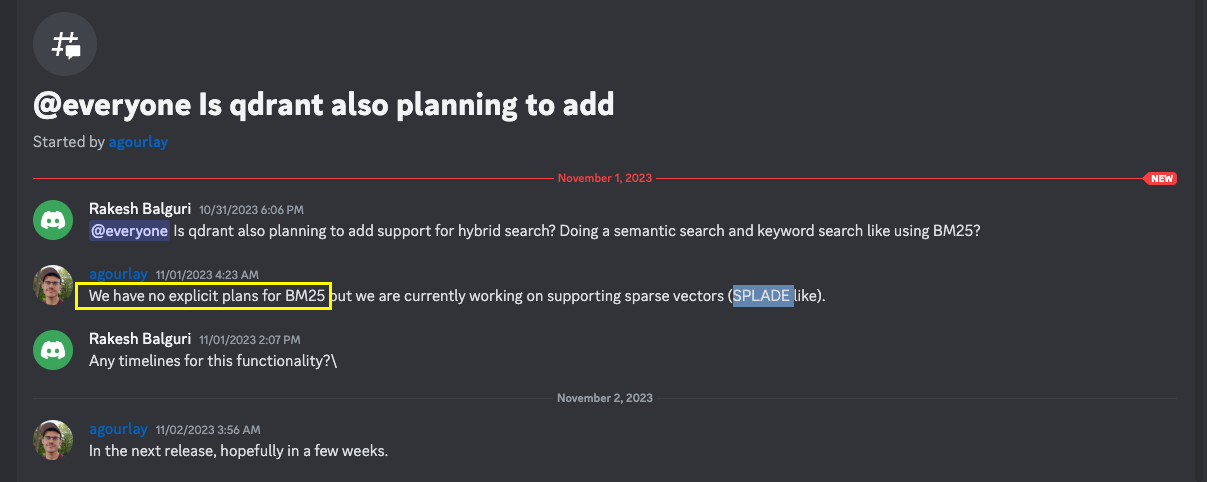


In [18]:
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 3

In [13]:
from qdrant_client import QdrantClient
client = QdrantClient(path="./qdrant_storage/")
embeddings = OpenAIEmbeddings()
collection_name = "toronto_sf"
qdrant=Qdrant(client=client, collection_name=collection_name, embeddings=embeddings)

In [19]:
vector_retriever = qdrant.as_retriever(search_kwargs={"k": 3})

In [20]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever], weights=[0.8, 0.2]
)

In [21]:
docs = ensemble_retriever.get_relevant_documents("compare population of toronto and san francisco")
pretty_print_docs(docs)

Document 1:

In the 2021 Census of Population conducted by Statistics Canada, Toronto had a population of 2,794,356 living in 1,160,892 of its 1,253,238 total private dwellings, a change of 2.3% from its 2016 population of 2,731,571. With a land area of 631.1 km2 (243.7 sq mi), it had a population density of 4,427.8/km2 (11,467.8/sq mi) in 2021.  
At the census metropolitan area (CMA) level in the 2021 census, the Toronto CMA had a population of 6,202,225 living in 2,262,473 of its 2,394,205 total private dwellings, a change of 4.6% from its 2016 population of 5,928,040. With a land area of 5,902.75 km2 (2,279.06 sq mi), it had a population density of 1,050.7/km2 (2,721.4/sq mi) in 2021.  
In 2016, persons aged 14 years and under made up 14.5 per cent of the population, and those aged 65 years and over made up 15.6 per cent. The median age was 39.3 years. The city's gender population is 48 per cent male and 52 per cent female. Women outnumber men in all age groups 15 and older.
-------

As the result shows, it looks like the keyword search is negatively affected by the word "compare" and we don't have any documents related to San Francisco.